In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import pandas as pd
from filter_tc.sdypy_sep005_pandas import *
from filter_tc.particle_filter import *
import datetime
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'filter_tc.sdypy_sep005_pandas'

In [ ]:
start = datetime.datetime(2022, 9, 1)
end = datetime.datetime(2022, 9, 2)
data_path = \
    "_".join(
        [
            "../data/scb/almere/strain/raw/strain_data",
            str(start.year),
            str(start.month),
            str(start.day),
            str(end.year),
            str(end.month),
            str(end.day),
            ".parquet"
        ]
    )
strain_data = pd.read_parquet(data_path)


In [ ]:
BCN_data = strain_data.filter(regex='BCN')
TCN_data = strain_data.filter(regex='TCN')
TFBG_data = strain_data.filter(regex='TFBG')
bottom_TFBG_data = TFBG_data.filter(regex='_B')
web_TFBG_data = TFBG_data.filter(regex='_W')
top_TFBG_dat = TFBG_data[TFBG_data.columns.difference(bottom_TFBG_data.columns).difference(web_TFBG_data.columns)]

BCN_sep005 = pandas_to_sep005(BCN_data, "BCN", "microstrain")
TCN_sep005 = pandas_to_sep005(TCN_data, "TCN", "microstrain")
TFBG_sep005 = pandas_to_sep005(TFBG_data, "TFBG", "microstrain")
bottom_TFBG_sep005 = pandas_to_sep005(bottom_TFBG_data, "bottom_TFBG", "microstrain")
web_TFBG_sep005 = pandas_to_sep005(web_TFBG_data, "web_TFBG", "microstrain")
top_TFBG_sep005 = pandas_to_sep005(top_TFBG_dat, "top_TFBG", "microstrain")

In [ ]:
start = 900100
stop = start + 100000
sensor = 2

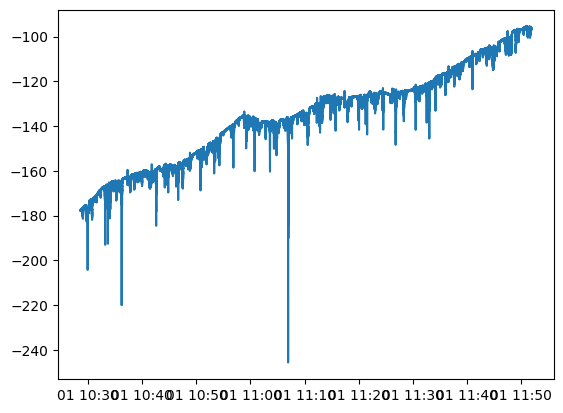

In [ ]:
plt.plot(TCN_data.iloc[start:stop,sensor])

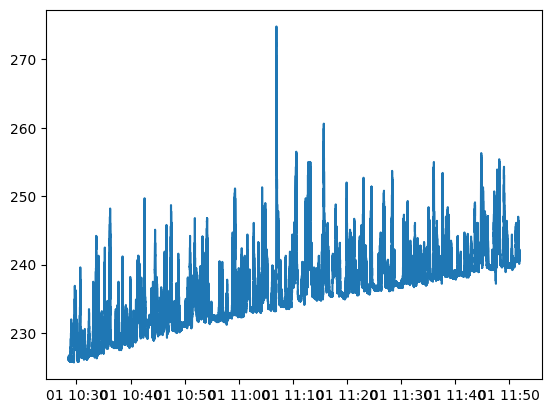

In [ ]:
plt.plot(BCN_data.iloc[start:stop,sensor])

In [ ]:
from sdypy_sep005.sep005 import assert_sep005
assert_sep005(TCN_sep005)

In [ ]:
bottom_TFBG_sep005

{'data': array([[16.2, 16.3, 16.2, ..., 17.3, 17.3, 17.3]]),
 'fs': 20.0,
 'name': 'bottom_TFBG',
 'time': array([['2022-08-31T22:00:00.000000', '2022-08-31T22:00:00.050000',
         '2022-08-31T22:00:00.100000', ..., '2022-09-01T21:59:59.850000',
         '2022-09-01T21:59:59.900000', '2022-09-01T21:59:59.950000']],
       dtype='datetime64[us]'),
 'channel_names': Index(['SCB_ALM_BCS_TFBG_HOR002'], dtype='object'),
 'unit_str': 'microstrain'}

In [ ]:
start = 900100
stop = start + 100000
sensor = 3
pf = \
    ParticleFilter(
        num_particles = 100,
        r_measurement_noise = 1e2,
        q_process_noise = np.array([5e-3, 1]),
        scale = 1e-3
    )

measurements = BCN_sep005["data"][sensor][start:stop]
inputs = np.vstack([
        bottom_TFBG_sep005['data'][0],
        np.concatenate([np.array([0]), np.diff(bottom_TFBG_sep005['data'][0])])
    ])[:, start:stop]

filtered_data = pf.filter(
    measurements,
    inputs,
    loading = 'tension'
)

100000
0 245.37210572892192 245.5
1 245.4900619013417 245.8
2 245.50236190032734 245.6
3 245.47341953291198 245.5
4 245.4665132013178 245.8
5 245.35027171240193 245.8
6 245.35903708738422 245.8
7 245.45556922700953 245.8
8 245.3311015730181 245.8
9 245.33612364940544 245.8
10 245.4308271637113 245.5
11 245.32954524254976 245.5
12 245.33427293755813 245.8
13 245.34308070164298 245.8
14 245.44781394712547 245.8
15 245.1699536031795 245.1
16 245.2693582197024 245.6
17 245.26976846539662 245.6
18 245.2704396272305 245.5
19 245.16906956029032 245.6
20 245.2670002248026 245.8
21 245.26568738229722 245.5
22 245.2656167773515 245.5
23 245.26399308452594 245.6
24 245.16199119149806 245.6
25 245.16191619057824 245.5
26 245.26255367757284 245.3
27 245.26333542874363 245.6
28 245.26111735393698 245.5
29 245.26131902863997 245.5
30 245.26080772112937 245.6
31 245.25945073212236 245.6
32 245.25714428038887 245.8
33 245.1569126382569 245.8
34 245.1587937434665 245.5
35 245.26143165260586 245.5
36 245

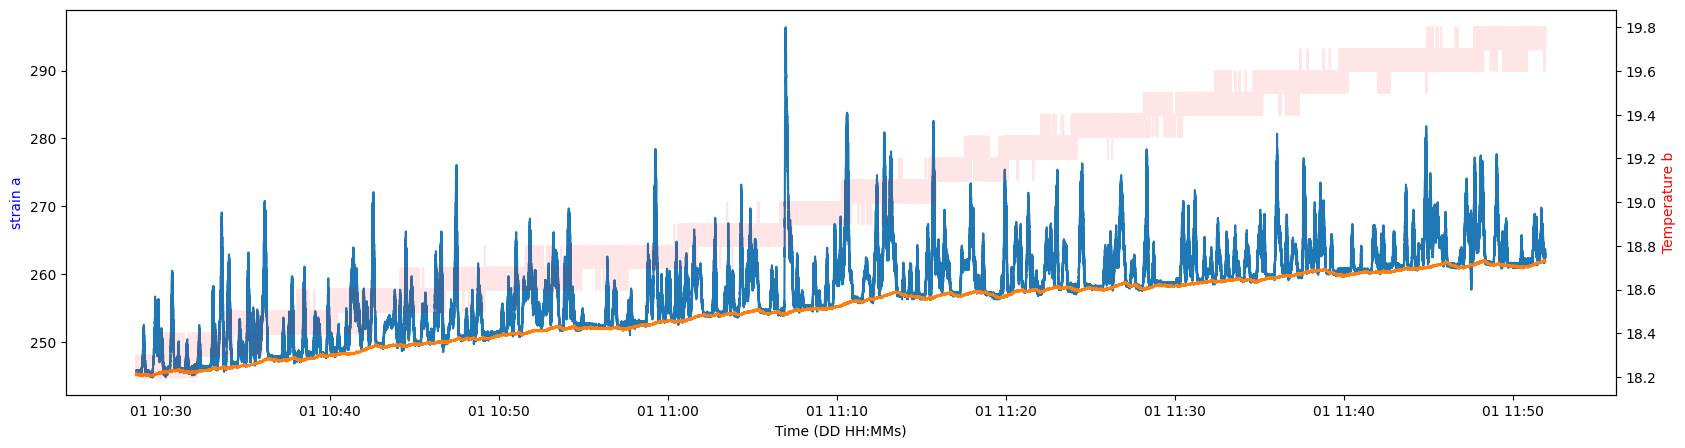

In [ ]:
filtered_data = pd.DataFrame(
    {
        'predictions': pf.predictions
    },
    index = BCN_sep005["time"][sensor][start:stop]
)

measurements_data = pd.DataFrame(
    {
        'measurements': measurements
    },
    index = BCN_sep005["time"][sensor][start:stop]
)

inputs_data = pd.DataFrame(
    {
        'inputs': inputs[0]
    },
    index = BCN_sep005["time"][sensor][start:stop]
)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()

# Plot the data on the respective axes
ax2.plot(inputs_data, color='red', alpha = 0.1)
ax1.plot(measurements_data)
ax1.plot(filtered_data)

# Set the labels and limits for the axes
ax1.set_xlabel('Time (DD HH:MMs)')
ax1.set_ylabel('strain a', color='blue')
ax2.set_ylabel('Temperature b', color='red')
# Show the plot
plt.show()

In [ ]:
start = 900100
stop = start + 100000


pf = \
    ParticleFilter(
        num_particles = 500,
        r_measurement_noise = 1e5,
        q_process_noise = np.array([2e-2, 1e-1]),
        scale = 1e-3
    )

measurements = TCN_sep005["data"][sensor][start:stop]
inputs = np.vstack([
        top_TFBG_sep005['data'][0],
        np.concatenate([np.array([0]), np.diff(top_TFBG_sep005['data'][0])])
    ])[:, start:stop]

filtered_data = pf.filter(
    measurements,
    inputs,
    loading = 'compression'
)

100000
0 -164.0001549038494 -164.1
1 -163.97618257076064 -164.0
2 -163.97825013957052 -164.0
3 -163.9174314922016 -163.9
4 -163.92342658944423 -164.0
5 -164.01251047701987 -164.0
6 -163.9085043204009 -163.9
7 -164.00419228883226 -164.0
8 -163.90134232821785 -163.9
9 -163.93898594362668 -163.9
10 -163.8385759197889 -164.0
11 -163.93486143554338 -164.0
12 -163.83018813319342 -163.9
13 -163.82627125904116 -164.0
14 -163.91157143493064 -163.9
15 -163.8150842350769 -163.9
16 -163.91135442770596 -164.0
17 -163.90553072720292 -163.9
18 -163.89511280872614 -163.9
19 -163.7952076303824 -163.9
20 -163.79302003368642 -163.9
21 -163.79569773649365 -164.0
22 -163.79124558337847 -163.9
23 -163.7902171950381 -163.9
24 -163.7904917949843 -163.9
25 -163.78939154644135 -163.9
26 -163.7837853790507 -163.9
27 -163.78493579638007 -163.9
28 -163.7889547403042 -163.9
29 -163.78629684544418 -163.9
30 -163.87311852296406 -163.9
31 -163.76673224596522 -164.1
32 -163.85952868758756 -163.9
33 -163.86097648611013 

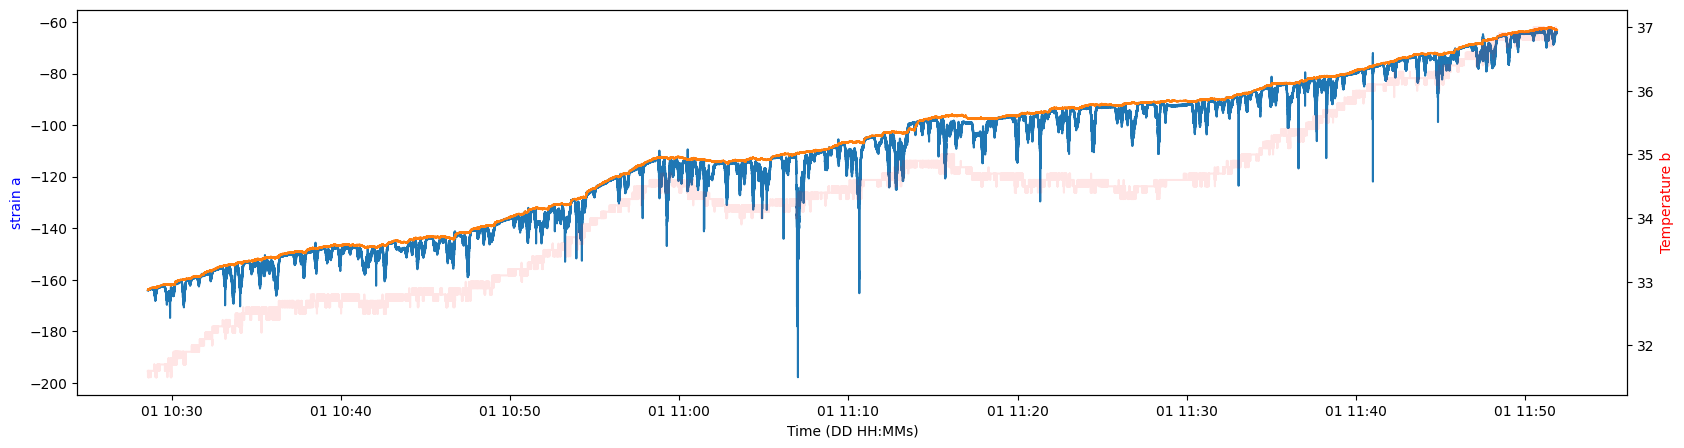

In [ ]:
filtered_data = pd.DataFrame(
    {
        'predictions': pf.predictions
    },
    index = BCN_sep005["time"][sensor][start:stop]
)

measurements_data = pd.DataFrame(
    {
        'measurements': measurements
    },
    index = BCN_sep005["time"][sensor][start:stop]
)

inputs_data = pd.DataFrame(
    {
        'inputs': inputs[0]
    },
    index = BCN_sep005["time"][sensor][start:stop]
)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()

# Plot the data on the respective axes
ax2.plot(inputs_data, color='red', alpha = 0.1)
ax1.plot(measurements_data)
ax1.plot(filtered_data)

# Set the labels and limits for the axes
ax1.set_xlabel('Time (DD HH:MMs)')
ax1.set_ylabel('strain a', color='blue')
ax2.set_ylabel('Temperature b', color='red')
# Show the plot
plt.show()